epoch: 60 loss: 0.6275666035431171
0.001
epoch: 59 loss: 0.4540665347329755
0.001
epoch: 58 loss: 0.4498599915245146
0.001
epoch: 57 loss: 0.4479553876999591
0.001
epoch: 56 loss: 0.4476453613760104
0.001
epoch: 55 loss: 0.4470786551066228
0.001
epoch: 54 loss: 0.44664222416886046
0.001
epoch: 53 loss: 0.4464606281815702
0.001
epoch: 52 loss: 0.44633586224754984
0.001
epoch: 51 loss: 0.4463261789610516
0.001
epoch: 50 loss: 0.44611104983859434
0.001
epoch: 49 loss: 0.446123200286381
0.001
epoch: 48 loss: 0.44591810038362556
0.001
epoch: 47 loss: 0.4458954303925623
0.001
epoch: 46 loss: 0.4458273471480034
0.001
epoch: 45 loss: 0.44572613616247564
0.001
epoch: 44 loss: 0.4454137669253076
0.001
epoch: 43 loss: 0.4454910825468516
0.001
epoch: 42 loss: 0.44512369476958974
0.001
epoch: 41 loss: 0.44524326754328264
0.001
epoch: 40 loss: 0.44526605949563697
0.001
epoch: 39 loss: 0.445136054843356
0.001
epoch: 38 loss: 0.44473880897112095
0.001
epoch: 37 loss: 0.4448887853369088
0.001
epoch: 36

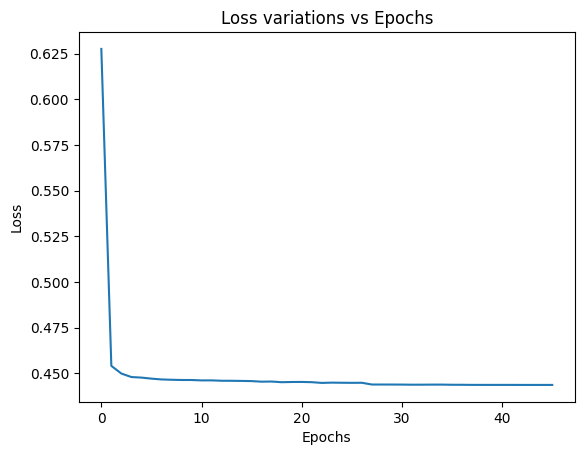

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

df=pd.read_csv('https://raw.githubusercontent.com/ksatola/Medical-Appointments-No-Shows/refs/heads/master/noshowappointments-kagglev2-may-2016.csv',nrows=50000)

# Data Pre-processing
# df.describe(include=['int64','float64','object']) # To check for inconsistent entries and empty entries
# df[df.duplicated()==True] # Ensure that there are no entirely duplicate rows
df=df.rename(columns={'Hipertension':'Hypertension','Handcap':'Handicap'})

df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'])
df['Waiting_period']=df['AppointmentDay']-df['ScheduledDay']
df['Waiting_period']=df['Waiting_period'].dt.days.astype(int)

#df[(df['Waiting_period']==-1)&(df['ScheduledDay'].dt.day!=df['AppointmentDay'].dt.day)] #Shows that this subset of data is not inconsistent
df=df.drop(df[df['Waiting_period']==-2].index)
df=df.reset_index(drop=True)
df['Waiting_period']=1+df['Waiting_period']
df=df.drop(columns=['ScheduledDay','AppointmentDay'])
# Each of the columns have significant standard deviation and so no redundancy based on variance.
# cols=df.iloc[:,7:13].columns
# print(cols)
# for  x in cols:
#   print(f"{x} {df[df[x]==1].index.size} {df[df[x]==0].index.size}")

#One-hot encoding
df['Gender']=df['Gender'].map({'M':0,'F':1})
df['No-show']=df['No-show'].map({'No':0,'Yes':1})

cols=list(df.columns)
df=df[cols[0:11]+[cols[12]]+[cols[11]]]

# from scipy.stats import chi2_contingency
# test_df=pd.crosstab(df['Neighbourhood'],df['No-show']).reset_index()
# test_df=test_df.rename(columns={0:'No',1:'Yes'})
# print(test_df)
# contingency_table=test_df[['No','Yes']]
# chi2, p, dof, expected = chi2_contingency(contingency_table)
# print('p-value: ',p)

series=df.groupby('Neighbourhood').count()['No-show']
df['Neighbourhood']=df['Neighbourhood'].map(series)
df['Neighbourhood']=df['Neighbourhood']*100/df.index.size

# fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(10,5))
# cols=['PatientId','AppointmentID','Age','Neighbourhood','Waiting_period']
# axes=axes.flatten()
# for i in range(0,len(cols)):
#   ax=axes[i]
#   ax.boxplot(df[cols[i]])
#   ax.set_title(cols[i])

# plt.tight_layout()
# plt.show()

# df['Neighbourhood'].describe()

cols=['PatientId','AppointmentID','Age']
for x in cols:
  df[x]=(df[x]-df[x].mean())/df[x].std()
# df['PatientId'].describe()

# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# X=add_constant(df)
# vif_data=pd.DataFrame()
# vif_data['feature']=X.columns
# vif_data['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

target=np.array(df['No-show'])
df=df.drop(columns=['No-show'])

# Py-torch implementation

X_tensor=torch.tensor(df.values,dtype=torch.float32)
y_tensor=torch.tensor(target.reshape(-1,1),dtype=torch.float32)

data=TensorDataset(X_tensor,y_tensor)
batch_size=64
loaded_data=DataLoader(data,batch_size,shuffle=True)

class VNN(nn.Module):
    def __init__(self, layers):
        super(VNN, self).__init__()
        self.layers=nn.ModuleList(layers)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for i in range(0,len(self.layers)):
          x=self.sigmoid(self.layers[i](x))
        return x

dims=[(12,128),(128,64),(64,1)]
weights=[]
biases=[]
for in_dim,out_dim in dims:
   limit = np.sqrt(6/(in_dim+out_dim))
   weights.append(np.linspace(-limit,limit,in_dim*out_dim).reshape(out_dim,in_dim))
   biases.append(np.zeros(out_dim))

Layer1=nn.Linear(12,128)
Layer2=nn.Linear(128,64)
Output_layer=nn.Linear(64,1)

with torch.no_grad():
  layers=[Layer1,Layer2,Output_layer]
  for i in range(0,len(layers)):
    layers[i].weight.copy_(torch.from_numpy(weights[i]))
    layers[i].bias.copy_(torch.from_numpy(biases[i]))

VNN_model=VNN(layers)

criterion=nn.BCELoss()
optimiser=optim.Adam(VNN_model.parameters(),lr=0.001)

def Grad_descent():
  max_epochs=60
  lr_min=1e-6
  loss_progression=[]
  scheduler= ReduceLROnPlateau(optimiser,mode='min',factor=0.1,patience=3)
  while max_epochs:
    epoch_loss=0
    for X_batch,y_batch in loaded_data:
      y_pred=VNN_model(X_batch)
      loss=criterion(y_pred,y_batch)

      optimiser.zero_grad()
      loss.backward()
      optimiser.step()
      epoch_loss+=loss.item()*X_batch.shape[0]

    epoch_loss/=len(data)
    scheduler.step(epoch_loss)
    loss_progression.append(epoch_loss)
    print(f"epoch: {max_epochs} loss: {epoch_loss}")
    current_lr=optimiser.param_groups[0]['lr']
    print(current_lr)
    if current_lr<=lr_min:
      break
    max_epochs-=1
  return loss_progression

loss_vect=Grad_descent()

with torch.no_grad():
  plt.plot(loss_vect)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss variations vs Epochs")
  plt.show()





0.44413468533485506
[[8049    0]
 [1950    0]]


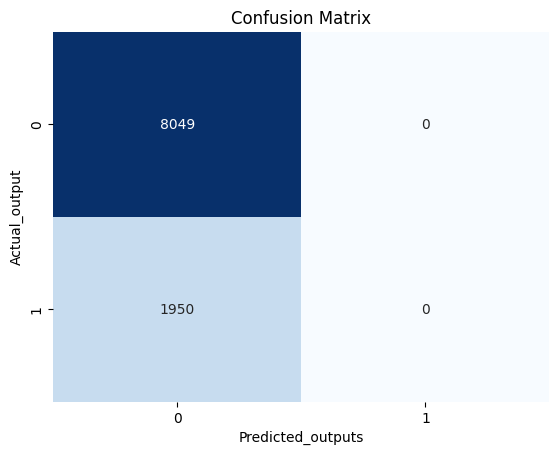

In [16]:
VNN_model.eval()

with torch.no_grad():
  from sklearn.metrics import confusion_matrix
  val_df=pd.read_csv('https://raw.githubusercontent.com/ksatola/Medical-Appointments-No-Shows/refs/heads/master/noshowappointments-kagglev2-may-2016.csv',skiprows=60000,nrows=10000)

  val_df.columns=pd.Series(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
        'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
        'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'])

  val_df['ScheduledDay']=pd.to_datetime(val_df['ScheduledDay'])
  val_df['AppointmentDay']=pd.to_datetime(val_df['AppointmentDay'])
  val_df['Waiting_period']=val_df['AppointmentDay']-val_df['ScheduledDay']
  val_df['Waiting_period']=val_df['Waiting_period'].dt.days.astype(int)

  val_df=val_df.drop(val_df[val_df['Waiting_period']==-2].index)
  val_df=val_df.reset_index(drop=True)
  val_df['Waiting_period']=1+val_df['Waiting_period']
  val_df=val_df.drop(columns=['ScheduledDay','AppointmentDay'])

  val_df['Gender']=val_df['Gender'].map({'M':0,'F':1})
  val_df['No-show']=val_df['No-show'].map({'No':0,'Yes':1})

  cols=list(val_df.columns)
  val_df=val_df[cols[0:11]+[cols[12]]+[cols[11]]]

  series=val_df.groupby('Neighbourhood').count()['No-show']
  val_df['Neighbourhood']=val_df['Neighbourhood'].map(series)
  val_df['Neighbourhood']=val_df['Neighbourhood']*100/val_df.index.size


  cols=['PatientId','AppointmentID','Age']
  for x in cols:
    val_df[x]=(val_df[x]-val_df[x].mean())/val_df[x].std()

  target=np.array(val_df['No-show'])
  val_df=val_df.drop(columns=['No-show'])

  eps=1e-8
  loss=0
  X=val_df
  y=target

  X_tensor=torch.tensor(X.values,dtype=torch.float32)
  y_tensor=torch.tensor(y.reshape(-1,1),dtype=torch.float32)

  val_data=TensorDataset(X_tensor,y_tensor)
  batch_size=64
  loaded_valdata=DataLoader(val_data,batch_size)

  eps=1e-8
  final_loss=0

  predicted=[]
  for X_batch,y_batch in loaded_valdata:
    predicted_output=VNN_model(X_batch)
    predicted.extend(np.array((predicted_output>=0.5)).astype(int).flatten())
    loss=criterion(predicted_output,y_batch)

    final_loss+=loss.item()*X_batch.shape[0]

  final_loss/=len(val_data)
  print(final_loss)

  ConfusionMatrix=confusion_matrix(y,predicted)
  print(ConfusionMatrix)

  sns.heatmap(ConfusionMatrix,annot=True,fmt='d',cmap='Blues',cbar=False)
  plt.xlabel('Predicted_outputs')
  plt.ylabel('Actual_output')
  plt.title('Confusion Matrix')
  plt.show()



In [12]:
VNN_model.eval()

with torch.no_grad():
  test_df=pd.read_csv('https://raw.githubusercontent.com/ksatola/Medical-Appointments-No-Shows/refs/heads/master/noshowappointments-kagglev2-may-2016.csv',skiprows=50000,nrows=10000)

  test_df.columns=pd.Series(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
        'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
        'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'])

  test_df['ScheduledDay']=pd.to_datetime(test_df['ScheduledDay'])
  test_df['AppointmentDay']=pd.to_datetime(test_df['AppointmentDay'])
  test_df['Waiting_period']=test_df['AppointmentDay']-test_df['ScheduledDay']
  test_df['Waiting_period']=test_df['Waiting_period'].dt.days.astype(int)

  test_df=test_df.drop(test_df[test_df['Waiting_period']==-2].index)
  test_df=test_df.reset_index(drop=True)
  test_df['Waiting_period']=1+test_df['Waiting_period']
  test_df=test_df.drop(columns=['ScheduledDay','AppointmentDay'])

  test_df['Gender']=test_df['Gender'].map({'M':0,'F':1})
  test_df['No-show']=test_df['No-show'].map({'No':0,'Yes':1})

  cols=list(test_df.columns)
  test_df=test_df[cols[0:11]+[cols[12]]+[cols[11]]]

  series=test_df.groupby('Neighbourhood').count()['No-show']
  test_df['Neighbourhood']=test_df['Neighbourhood'].map(series)
  test_df['Neighbourhood']=test_df['Neighbourhood']*100/test_df.index.size


  cols=['PatientId','AppointmentID','Age']
  for x in cols:
    test_df[x]=(test_df[x]-test_df[x].mean())/test_df[x].std()

  target=np.array(test_df['No-show'])
  test_df=test_df.drop(columns=['No-show'])

  X_tensor=torch.tensor(test_df.values,dtype=torch.float32)
  y_tensor=torch.tensor(target.reshape(-1,1),dtype=torch.float32)

  test_data=TensorDataset(X_tensor,y_tensor)
  batch_size=64
  loaded_testdata=DataLoader(test_data,batch_size)

  eps=1e-8
  final_loss=0

  for X_batch,y_batch in loaded_testdata:
    predicted_output=VNN_model(X_batch)
    loss=criterion(predicted_output,y_batch)

    final_loss+=loss.item()*X_batch.shape[0]
  final_loss/=len(test_data)
  print(final_loss)





0.5683008194273741
